**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[Video](./project_video_out.mp4)


### Dataset visualize
I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![dataset](./out_img/dataset.png)

### Histogram of Oriented Gradients (HOG)

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

I tried various combinations of parameters and here is my final HOG parameters using the `YCrCb` color space.
- orientations=12
- pixels_per_cell=(8, 8)
- cells_per_block=(2, 2)

I selecting the parameters with considering of the accuracy. Usually, I will pick up the best accuracy 
![hog](./out_img/hog.png)


### Discussion

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import glob
from lesson_functions import *
from helper import *
import time
from sklearn.svm import LinearSVC
import pickle
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

Number of images :  8792
Image shape :  (64, 64, 3)
Image min :  0.113725
Image max :  0.694118
Image data type :  float32


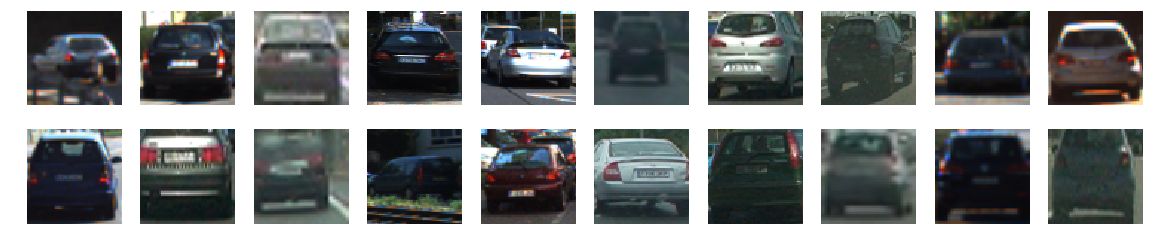

Number of images :  8968
Image shape :  (64, 64, 3)
Image min :  0.156863
Image max :  1.0
Image data type :  float32


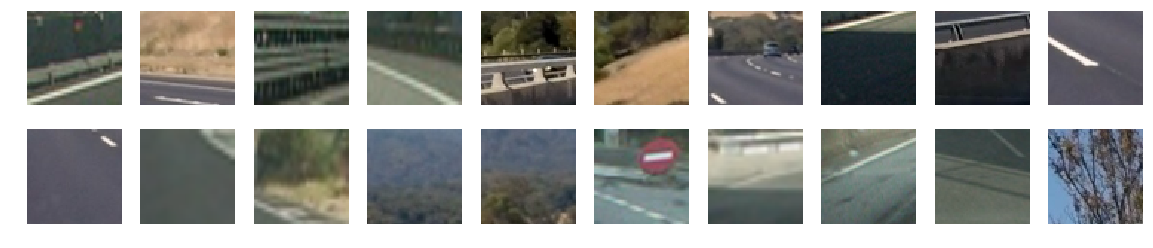

In [2]:
img_vehicle = glob.glob("data/vehicles/*/*.png")
img_nonvehicle = glob.glob("data/non-vehicles/*/*.png")
display_dataset(img_vehicle)
display_dataset(img_nonvehicle)

(-0.5, 63.5, 63.5, -0.5)

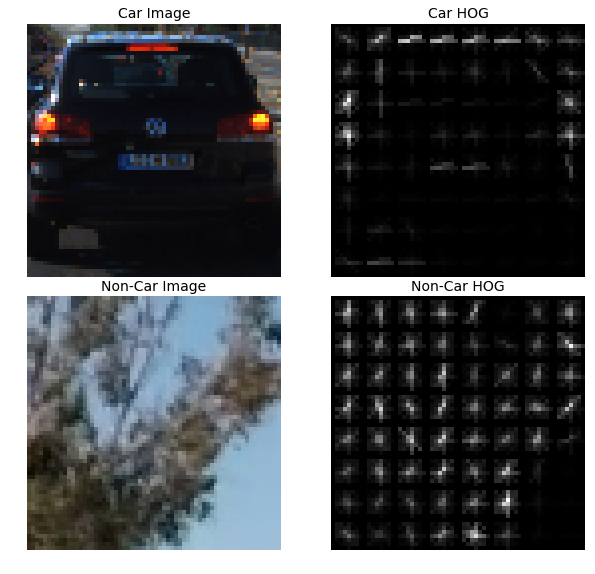

In [52]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(img_vehicle))
ind2 = np.random.randint(0, len(img_vehicle))
car = mpimg.imread(img_vehicle[ind])
non_car = mpimg.imread(img_nonvehicle[ind2])
gray_car = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
gray_noncar = cv2.cvtColor(non_car, cv2.COLOR_RGB2GRAY)

# Feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size,hist_bins = (32, 32), 32
# Call our function with vis=True to see an image output
features_car, hog_image_car = get_hog_features(gray_car, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
features_noncar, hog_image_noncar = get_hog_features(gray_noncar, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .004, wspace=.2)
ax1.imshow(car)
ax1.set_title('Car Image', fontsize=14)
ax1.axis('off')
ax2.imshow(hog_image_car, cmap='gray')
ax2.set_title('Car HOG', fontsize=14)
ax2.axis('off')
ax3.imshow(non_car)
ax3.set_title('Non-Car Image', fontsize=14)
ax3.axis('off')
ax4.imshow(hog_image_noncar, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=14)
ax4.axis('off')

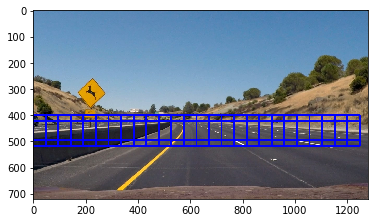

In [91]:
img = mpimg.imread('./test_images/test2.jpg')
h,w,c = img.shape
windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 496], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=[423, 519], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows = windows1 + windows2
window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)

In [88]:
# my accuracy able to achieve 0.9952 with HLS ,(32,32),16
# But, the detection is too sensitive so I change back to YCrCb
car_features = extract_features(img_vehicle,color_space=color_space, 
                    orient=orient, pix_per_cell=pix_per_cell, spatial_size=spatial_size,hist_bins=hist_bins,
                    cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(img_nonvehicle, color_space=color_space, 
                    orient=orient, pix_per_cell=pix_per_cell, spatial_size=spatial_size,hist_bins=hist_bins,
                    cell_per_block=cell_per_block, hog_channel=hog_channel)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test, X_scaler = feature_train_test_split(car_features,notcar_features)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time() # Prediction time for a single sample
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

X_train shape: (14208, 10224)
14208 train samples
3552 test samples
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 10224
4.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9938
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00121 Seconds to predict 10 labels with SVC


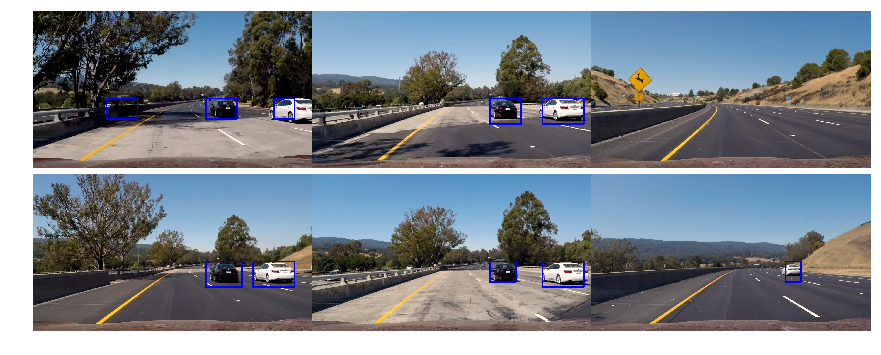

In [89]:
def process_image(image):
    rect = []
    ystart, ystop, scale = calc_sliding_windows(400,1.5)
    rect.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))
    ystart, ystop, scale = calc_sliding_windows(423,1.5)
    rect.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space))
    
    rect = [item for sublist in rect for item in sublist]
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,rect) # Add heat to each box in box list
    heat = apply_threshold(heat,1) # Apply threshold to help remove false positives
    heatmap = np.clip(heat, 0, 255) # Visualize the heatmap when displaying    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(2, 3, figsize=(15,6))
fig.subplots_adjust(hspace = .0, wspace=.0)
axs = axs.ravel()
for i, img in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(img)))
    axs[i].axis('off')


In [90]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.video.VideoClip import VideoClip
from IPython.display import HTML
challenge_output = './project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
#.subclip(0,50)
challenge_clip = clip.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [03:18<00:00,  6.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 5min 38s, sys: 52.1 s, total: 6min 30s
Wall time: 3min 19s


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(64,64,3), output_shape=(64,64,3)))
    model.add(Convolution2D(10, 3, 3, activation='elu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='elu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(4,4)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(128,16,16,activation="elu")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,activation="tanh")) # This was Dense(1)
    model.add(Flatten())
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.compile(loss='mse',optimizer='sgd',metrics=['accuracy'])
model.summary()
model.fit(X_train, Y_train, batch_size=32, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("localize.h5")